In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import utm
import numpy as np
import matplotlib.ticker as ticker
from itertools import groupby
import os, os.path
import seaborn as sns
from datetime import datetime
from sklearn import metrics
from sklearn import preprocessing
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from scipy.special import rel_entr
from scipy.special import kl_div
from sklearn.metrics import davies_bouldin_score
import sys
import csv, io
from computeDistanceMatrix import computeDistanceMatrix
from findKNN import findKNN
from sharedNearest import sharedNearest, countIntersection
from density import density
from identifyCorePoints import identifyCorePoints
from core import core
from findCoreNeighbors import findCoreNeighbors
from expandCluster import expandCluster

In [2]:
# load the data set
df = pd.read_csv('User_045_latlontime.csv', encoding='utf-8')
df = df.iloc[: , 1:]
df.head()

,Latitude,Longitude,Time
0,4.424139e+06,442696.955368,6.285278
1,4.424135e+06,442705.633156,6.286667
2,4.424135e+06,442711.358548,6.288056
3,4.424169e+06,442712.550903,6.289444
4,4.424196e+06,442712.159252,6.290833


In [3]:
coords = df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = df['Time'].values.tolist()

In [4]:
#Finding minimum and maximum points from user data
lats_index_min = np.argmin(lats_xy)
lats_index_max = np.argmax(lats_xy)
longs_index_min = np.argmin(longs_xy)
longs_index_max = np.argmax(longs_xy)

#Defining the boundary points
p1_xy = (longs_xy[longs_index_min],lats_xy[lats_index_min])
p2_xy = (longs_xy[longs_index_min],lats_xy[lats_index_max])
p3_xy = (longs_xy[longs_index_max],lats_xy[lats_index_min])
p4_xy = (longs_xy[longs_index_max],lats_xy[lats_index_max])

In [5]:
#Initialize values to partition along number of grids n each axis
x=10
y=10
z=24

### Mapping of points in a 3D space-time grid and calculate distance using KL-divergence after addition of each new point

In [6]:
X = np.linspace((longs_xy[longs_index_min]),(longs_xy[longs_index_max]),x)
Y = np.linspace((lats_xy[lats_index_min]),(lats_xy[lats_index_max]), y)
Z = np.linspace(0,z,z)

grids_index = np.zeros((x,y,z))
point_count_inside_grid = np.zeros((1,x*y*z))
flat_hist = np.ones((1,x*y*z))
d=1
kl_pq = np.zeros((1,len(coords)))

for t in range(z):
    for yax in range(y):
        for xax in range(x):
            grids_index[xax,yax,t]=d
            d=d+1

for counter in range(len(coords)):
    p_lat = lats_xy[counter]
    p_long = longs_xy[counter]
    p_time = user_time[counter]
    for t in range(z):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(y):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(x):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            normalizedData = (point_count_inside_grid-np.min(point_count_inside_grid))/(np.max(point_count_inside_grid)-np.min(point_count_inside_grid))
                            #distance = sum(rel_entr(normalizedData, flat_hist)[0,:])
                            distance = sum(kl_div(normalizedData[0,:], flat_hist[0,:]))
                            #kl_pq[:,counter] = abs(distance)
                            kl_pq[:,counter] = distance

### Normalizing the data points

In [7]:
scaler = MinMaxScaler()
model=scaler.fit(df)
scaled_data=model.transform(df)
normalized_data = pd.DataFrame(scaled_data, columns = ['Latitude','Longitude','Time'])

### Clustering of raw normalized data

In [8]:
# Store the Pre-process the data
latitude = normalized_data['Latitude'].to_numpy()
longitude = normalized_data['Longitude'].to_numpy()
time_user = normalized_data['Time'].to_numpy()

In [9]:
def main():
    k=60
    minPoints=30
    eps = 15
    #To find spatial-temporal distance matrix
    distanceMatrix = computeDistanceMatrix(latitude, longitude, time_user)
    # To find K-nearest neighbors
    similarityMatrix = findKNN(distanceMatrix, k)
    count = len(latitude)
    sharedNearestNeighbor = sharedNearest(count, k, similarityMatrix)
    SNN_density = np.array([None for i in range(len(sharedNearestNeighbor))])
    for temp1 in range(len(sharedNearestNeighbor)):
        SNN_density[temp1] = density(sharedNearestNeighbor[temp1],eps, count)
    coreOrNot = np.array([None for i in range(len(SNN_density))])

    for temp1 in range(len(SNN_density)):
        coreOrNot[temp1]=identifyCorePoints(SNN_density[temp1], minPoints)
    corePoints1 = []
    SNN_density2 = list(zip(SNN_density, [i for i in range(len(SNN_density))]))
    for temp1 in range(len(SNN_density2)):
        corePoints1.append(core(SNN_density2[temp1][0],SNN_density2[temp1][1], minPoints))
    corePoints = np.array([x for x in corePoints1 if x!=None])
    visited=[]#list to store points visited
    labels=[0 for i in range(count)]
    neighborCore=[]#neighborss of core points
    c=0 

    for temp1 in range(0, len(corePoints)):
        p = corePoints[temp1]
        if p in visited:
            continue
        visited.append(p)
        c=c+1
        labels[p]=c
        neighborCore=findCoreNeighbors(p, corePoints, sharedNearestNeighbor, eps)
        labels = expandCluster(labels, neighborCore, corePoints, c, sharedNearestNeighbor, eps, visited)
    ## Compute final cluster labels
    #All points that are not within a radius of Eps of a core point are discarded (noise)
    #Assign all non-noise, non-core points to their nearest core point

    for temp1 in range(count):
        notNoise=False
        maxSim=sys.maxsize
        bestCore=-1
        sim=None
        if(coreOrNot[temp1]):
            continue
        for temp2 in range(len(corePoints)):
            p=corePoints[temp2]
            #sharedNearestNeighbor contains count of shared neighbors between points
           # sim gives the similarity  between core point and the other point.
            sim = sharedNearestNeighbor[temp1][p]
            # if sim is greater than eps--> the point is not a noise
            if(sim>=eps):
                notNoise=True
             # if sim is less than eps--> the point is  a noise point assign cluster index 0 to it
            else:
                labels[temp1]=0
                break
            #Here we attempt to see to which core point does the non-core point has maximum similarity
            if(sim>maxSim):
                maxSim=sim
                bestCore=p
            #End of inner for loop
        #for each non-core point assign the index of core point with which the point has maximum similarity
        if(notNoise):
            labels[temp1]=labels[bestCore]
    return labels

In [10]:
if __name__ == "__main__":
    labels=main()

Number of clusters are:  30


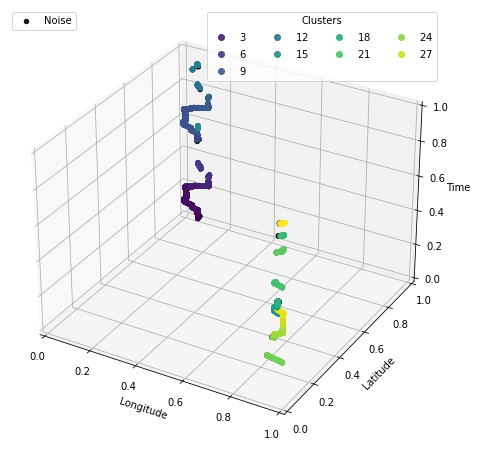

In [11]:
to_plot=normalized_data
to_plot.loc[:,'Label']=labels
noise_points = to_plot[to_plot.Label==0]
to_plot=to_plot[to_plot.Label!=0]
print('Number of clusters are: ',len(np.unique(labels)))

#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise')
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')
first_legend = ax.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=4, frameon=True)
plt.gca().add_artist(first_legend)
plt.legend(loc='upper left')
plt.show()

In [12]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, labels))

Silhouette Coefficient: 0.950


In [13]:
#Computing Davies-Bouldin Index
print(davies_bouldin_score(normalized_data, labels))

0.10539851840197832


### Find points that can be transmitted directly

In [14]:
max_limit = (0.1/100)*len(coords) 
new_data = []
scaled_points = []
for temp in range(kl_pq.size-1):
    if kl_pq[:,temp] != 0:
        percent_change = ((kl_pq[:,temp+1]-kl_pq[:,temp])/kl_pq[:,temp])*100
        if percent_change < 0:
            new_data.append(df.iloc[temp].tolist())
            scaled_points.append(scaled_data[temp].tolist())

In [15]:
new_df = pd.DataFrame(new_data, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(scaled_points, columns = ['Latitude','Longitude','Time'])

In [16]:
coords = new_df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = new_df['Time'].values.tolist()
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
d=1
new_points = []
new_scaled_points = []

In [17]:
# Store maximum of max_limit % points in a grid
for counter in range(len(coords)):
    p_lat = lats_xy[counter]
    p_long = longs_xy[counter]
    p_time = user_time[counter]
    for t in range(z):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(y):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(x):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            if point_count_inside_grid[:,int(found_at)] <= max_limit:
                                new_points.append(new_df.iloc[counter].tolist())
                                new_scaled_points.append(normalized_data.iloc[counter].tolist())

In [18]:
new_df = pd.DataFrame(new_points, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(new_scaled_points, columns = ['Latitude','Longitude','Time'])

### Plot directly transmitted normalized data points

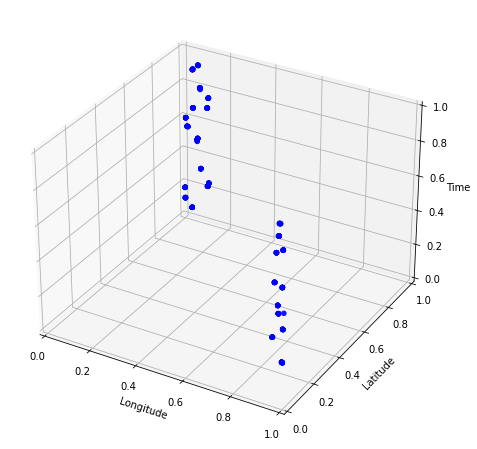

In [19]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')
plt.show()

### Clustering of directly transmitted data points

In [20]:
# Store the Pre-process the data
latitude = normalized_data['Latitude'].to_numpy()
longitude = normalized_data['Longitude'].to_numpy()
time_user = normalized_data['Time'].to_numpy()

In [21]:
if __name__ == "__main__":
    labels=main()

In [22]:
print(len(labels))

264


In [23]:
to_plot=normalized_data
to_plot.loc[:,'Label']=labels
noise_points = to_plot[to_plot.Label==0]
to_plot=to_plot[to_plot.Label!=0]
print('Number of clusters are: ',len(np.unique(labels)))

Number of clusters are:  2


Number of clusters are:  2


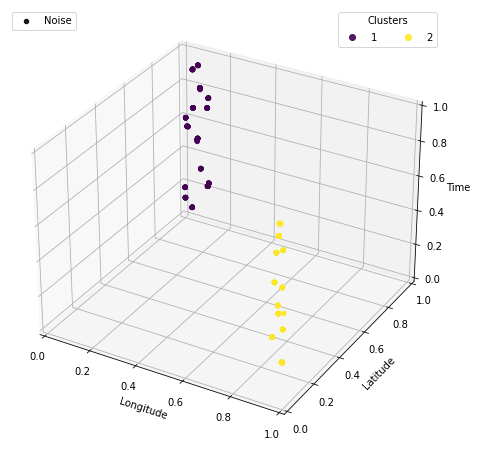

In [24]:
to_plot=normalized_data
to_plot.loc[:,'Label']=labels
noise_points = to_plot[to_plot.Label==0]
to_plot=to_plot[to_plot.Label!=0]
print('Number of clusters are: ',len(np.unique(labels)))

#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise')
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')
first_legend = ax.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=4, frameon=True)
plt.gca().add_artist(first_legend)
plt.legend(loc='upper left')
plt.show()

In [25]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, labels))

Silhouette Coefficient: 0.822


In [26]:
#Computing Davies-Bouldin Index
print(davies_bouldin_score(normalized_data, labels))

0.2726235086289384
